In [51]:
import sys
sys.path.append("..")
sys.path.append("../server")

from server.optimisation.models import *
from server.optimisation.gen_data import *

def getTicksForDay(id):
    day = Day.model_validate({"day": id, "deferables": getDefDemands(id)})
    ticks = []
    for tick in range(TICKS_PER_DAY):
        sun = getSunlight(tick)
        demand = getInstDemand(id, tick)
        sell, buy = getPrice(id, tick)

        ticks.append(
            Tick.model_validate(
                {
                    "tick": tick,
                    "sun": sun,
                    "demand": demand,
                    "sell_price": sell,
                    "buy_price": buy,
                    "day": id,
                }
            )
        )
    return day, ticks

In [72]:
tick_data = []
for i in range(5000):
    _, tmp = getTicksForDay(143038273 + i)
    tick_data += [tick.buy_price for tick in tmp]

tick_data

[11,
 36,
 29,
 26,
 22,
 13,
 15,
 8,
 11,
 31,
 28,
 11,
 33,
 34,
 39,
 53,
 32,
 20,
 46,
 30,
 40,
 25,
 11,
 13,
 17,
 25,
 13,
 12,
 5,
 10,
 5,
 5,
 13,
 6,
 24,
 16,
 9,
 12,
 18,
 35,
 25,
 37,
 36,
 43,
 46,
 45,
 75,
 61,
 47,
 47,
 37,
 51,
 40,
 61,
 43,
 40,
 52,
 31,
 35,
 9,
 5,
 31,
 29,
 15,
 13,
 16,
 16,
 24,
 16,
 22,
 34,
 29,
 21,
 35,
 29,
 41,
 27,
 54,
 42,
 16,
 54,
 38,
 17,
 13,
 17,
 17,
 12,
 5,
 20,
 27,
 5,
 13,
 5,
 8,
 20,
 22,
 5,
 5,
 38,
 24,
 34,
 31,
 26,
 63,
 40,
 39,
 47,
 65,
 62,
 64,
 58,
 37,
 51,
 53,
 45,
 38,
 39,
 23,
 34,
 25,
 19,
 27,
 21,
 34,
 5,
 6,
 20,
 35,
 5,
 5,
 12,
 26,
 12,
 17,
 50,
 37,
 36,
 38,
 45,
 18,
 29,
 25,
 25,
 20,
 10,
 29,
 5,
 14,
 5,
 7,
 5,
 5,
 35,
 5,
 9,
 7,
 24,
 25,
 36,
 44,
 21,
 42,
 53,
 39,
 26,
 53,
 44,
 37,
 54,
 55,
 56,
 41,
 44,
 31,
 42,
 29,
 34,
 38,
 31,
 11,
 12,
 23,
 5,
 5,
 28,
 16,
 30,
 22,
 8,
 22,
 31,
 34,
 24,
 31,
 31,
 47,
 32,
 27,
 44,
 40,
 27,
 21,
 27,
 26,
 14,
 20,

In [73]:
max(tick_data)

96

In [109]:
tick_data = [i/100 for i in tick_data]
tick_data

[0.11,
 0.36,
 0.29,
 0.26,
 0.22,
 0.13,
 0.15,
 0.08,
 0.11,
 0.31,
 0.28,
 0.11,
 0.33,
 0.34,
 0.39,
 0.53,
 0.32,
 0.2,
 0.46,
 0.3,
 0.4,
 0.25,
 0.11,
 0.13,
 0.17,
 0.25,
 0.13,
 0.12,
 0.05,
 0.1,
 0.05,
 0.05,
 0.13,
 0.06,
 0.24,
 0.16,
 0.09,
 0.12,
 0.18,
 0.35,
 0.25,
 0.37,
 0.36,
 0.43,
 0.46,
 0.45,
 0.75,
 0.61,
 0.47,
 0.47,
 0.37,
 0.51,
 0.4,
 0.61,
 0.43,
 0.4,
 0.52,
 0.31,
 0.35,
 0.09,
 0.05,
 0.31,
 0.29,
 0.15,
 0.13,
 0.16,
 0.16,
 0.24,
 0.16,
 0.22,
 0.34,
 0.29,
 0.21,
 0.35,
 0.29,
 0.41,
 0.27,
 0.54,
 0.42,
 0.16,
 0.54,
 0.38,
 0.17,
 0.13,
 0.17,
 0.17,
 0.12,
 0.05,
 0.2,
 0.27,
 0.05,
 0.13,
 0.05,
 0.08,
 0.2,
 0.22,
 0.05,
 0.05,
 0.38,
 0.24,
 0.34,
 0.31,
 0.26,
 0.63,
 0.4,
 0.39,
 0.47,
 0.65,
 0.62,
 0.64,
 0.58,
 0.37,
 0.51,
 0.53,
 0.45,
 0.38,
 0.39,
 0.23,
 0.34,
 0.25,
 0.19,
 0.27,
 0.21,
 0.34,
 0.05,
 0.06,
 0.2,
 0.35,
 0.05,
 0.05,
 0.12,
 0.26,
 0.12,
 0.17,
 0.5,
 0.37,
 0.36,
 0.38,
 0.45,
 0.18,
 0.29,
 0.25,
 0.25,
 0.2,
 0.1

In [123]:
# input = n previous price
# output is next price

n = 20

# each input = goup of n prices
# output = single value

def get_input(data, n):
    in_vals = []
    for i in range(len(data) - n):
        in_vals.append(data[i:i+n])

    return in_vals

def get_output(data, n):
    out_vals = []
    for i in range(n, len(data)):
        out_vals.append(data[i])
    
    return out_vals

In [124]:
in_vals = get_input(tick_data, n)
out_vals = get_output(tick_data, n)

print(len(in_vals), len(out_vals))

299980 299980


In [125]:
in_vals

[[0.11,
  0.36,
  0.29,
  0.26,
  0.22,
  0.13,
  0.15,
  0.08,
  0.11,
  0.31,
  0.28,
  0.11,
  0.33,
  0.34,
  0.39,
  0.53,
  0.32,
  0.2,
  0.46,
  0.3],
 [0.36,
  0.29,
  0.26,
  0.22,
  0.13,
  0.15,
  0.08,
  0.11,
  0.31,
  0.28,
  0.11,
  0.33,
  0.34,
  0.39,
  0.53,
  0.32,
  0.2,
  0.46,
  0.3,
  0.4],
 [0.29,
  0.26,
  0.22,
  0.13,
  0.15,
  0.08,
  0.11,
  0.31,
  0.28,
  0.11,
  0.33,
  0.34,
  0.39,
  0.53,
  0.32,
  0.2,
  0.46,
  0.3,
  0.4,
  0.25],
 [0.26,
  0.22,
  0.13,
  0.15,
  0.08,
  0.11,
  0.31,
  0.28,
  0.11,
  0.33,
  0.34,
  0.39,
  0.53,
  0.32,
  0.2,
  0.46,
  0.3,
  0.4,
  0.25,
  0.11],
 [0.22,
  0.13,
  0.15,
  0.08,
  0.11,
  0.31,
  0.28,
  0.11,
  0.33,
  0.34,
  0.39,
  0.53,
  0.32,
  0.2,
  0.46,
  0.3,
  0.4,
  0.25,
  0.11,
  0.13],
 [0.13,
  0.15,
  0.08,
  0.11,
  0.31,
  0.28,
  0.11,
  0.33,
  0.34,
  0.39,
  0.53,
  0.32,
  0.2,
  0.46,
  0.3,
  0.4,
  0.25,
  0.11,
  0.13,
  0.17],
 [0.15,
  0.08,
  0.11,
  0.31,
  0.28,
  0.11,
  0

In [126]:
out_vals

[0.4,
 0.25,
 0.11,
 0.13,
 0.17,
 0.25,
 0.13,
 0.12,
 0.05,
 0.1,
 0.05,
 0.05,
 0.13,
 0.06,
 0.24,
 0.16,
 0.09,
 0.12,
 0.18,
 0.35,
 0.25,
 0.37,
 0.36,
 0.43,
 0.46,
 0.45,
 0.75,
 0.61,
 0.47,
 0.47,
 0.37,
 0.51,
 0.4,
 0.61,
 0.43,
 0.4,
 0.52,
 0.31,
 0.35,
 0.09,
 0.05,
 0.31,
 0.29,
 0.15,
 0.13,
 0.16,
 0.16,
 0.24,
 0.16,
 0.22,
 0.34,
 0.29,
 0.21,
 0.35,
 0.29,
 0.41,
 0.27,
 0.54,
 0.42,
 0.16,
 0.54,
 0.38,
 0.17,
 0.13,
 0.17,
 0.17,
 0.12,
 0.05,
 0.2,
 0.27,
 0.05,
 0.13,
 0.05,
 0.08,
 0.2,
 0.22,
 0.05,
 0.05,
 0.38,
 0.24,
 0.34,
 0.31,
 0.26,
 0.63,
 0.4,
 0.39,
 0.47,
 0.65,
 0.62,
 0.64,
 0.58,
 0.37,
 0.51,
 0.53,
 0.45,
 0.38,
 0.39,
 0.23,
 0.34,
 0.25,
 0.19,
 0.27,
 0.21,
 0.34,
 0.05,
 0.06,
 0.2,
 0.35,
 0.05,
 0.05,
 0.12,
 0.26,
 0.12,
 0.17,
 0.5,
 0.37,
 0.36,
 0.38,
 0.45,
 0.18,
 0.29,
 0.25,
 0.25,
 0.2,
 0.1,
 0.29,
 0.05,
 0.14,
 0.05,
 0.07,
 0.05,
 0.05,
 0.35,
 0.05,
 0.09,
 0.07,
 0.24,
 0.25,
 0.36,
 0.44,
 0.21,
 0.42,
 0.53,
 0.39,
 0.

In [127]:
# train and test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(get_input(tick_data, n), get_output(tick_data, n), test_size=0.2)

print(len(X_train), len(X_test), len(y_train), len(y_test))

239984 59996 239984 59996


In [128]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# torch.set_default_tensor_type(torch.DoubleTensor)

In [129]:
class Model(nn.Module):
    def __init__(self, in_f = 2, hl1 = 128, hl2 = 128, out=1):
        super().__init__()
        self.fc1 = nn.Linear(in_f, hl1)
        self.fc2 = nn.Linear(hl1, hl2)
        self.out = nn.Linear(hl2, out)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)


In [130]:
model = Model(in_f=n)

In [131]:
X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.FloatTensor(y_train)

In [132]:
X_train_t

tensor([[0.4700, 0.5100, 0.4900,  ..., 0.0500, 0.2400, 0.2300],
        [0.2300, 0.5800, 0.5300,  ..., 0.2500, 0.3700, 0.3300],
        [0.2500, 0.1100, 0.0500,  ..., 0.4400, 0.2900, 0.4100],
        ...,
        [0.2200, 0.2900, 0.1300,  ..., 0.1200, 0.3100, 0.3900],
        [0.1100, 0.0500, 0.1100,  ..., 0.3000, 0.3000, 0.3400],
        [0.4100, 0.3700, 0.1900,  ..., 0.2600, 0.3100, 0.5500]])

In [133]:
y_train_t

tensor([0.2300, 0.4100, 0.2300,  ..., 0.4300, 0.4000, 0.4100])

In [136]:
# set criterion to measure error
criterion = nn.SmoothL1Loss()

# Adam Optimizer
# params = all the layers
# epoch = iteration -> sending data through the nn once
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [137]:
# training
epochs = 500
losses = []

for i in range(epochs):
    # send data forward
    y_pred = model.forward(X_train_t).squeeze()
    print(y_train_t)
    print(y_pred)

    loss = criterion(y_pred, y_train_t)

    losses.append(loss.detach().numpy())

    print(f'epoch: {i} and loss: {loss}')

    # back propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

tensor([0.2300, 0.4100, 0.2300,  ..., 0.4300, 0.4000, 0.4100])
tensor([0.2057, 0.1803, 0.2847,  ..., 0.3261, 0.3333, 0.3769],
       grad_fn=<SqueezeBackward0>)
epoch: 0 and loss: 0.004838082008063793
tensor([0.2300, 0.4100, 0.2300,  ..., 0.4300, 0.4000, 0.4100])
tensor([0.0534, 0.0629, 0.0531,  ..., 0.0992, 0.0496, 0.0921],
       grad_fn=<SqueezeBackward0>)
epoch: 1 and loss: 0.03248218819499016
tensor([0.2300, 0.4100, 0.2300,  ..., 0.4300, 0.4000, 0.4100])
tensor([0.1583, 0.1405, 0.1903,  ..., 0.2496, 0.2278, 0.2933],
       grad_fn=<SqueezeBackward0>)
epoch: 2 and loss: 0.00766801880672574
tensor([0.2300, 0.4100, 0.2300,  ..., 0.4300, 0.4000, 0.4100])
tensor([0.2614, 0.2468, 0.3341,  ..., 0.3803, 0.3955, 0.4558],
       grad_fn=<SqueezeBackward0>)
epoch: 3 and loss: 0.009579195640981197
tensor([0.2300, 0.4100, 0.2300,  ..., 0.4300, 0.4000, 0.4100])
tensor([0.2854, 0.2787, 0.3684,  ..., 0.4054, 0.4314, 0.4950],
       grad_fn=<SqueezeBackward0>)
epoch: 4 and loss: 0.0147780459374189

In [138]:
x = torch.FloatTensor(X_train[:100])
with torch.no_grad():
    y = model.forward(x).squeeze()

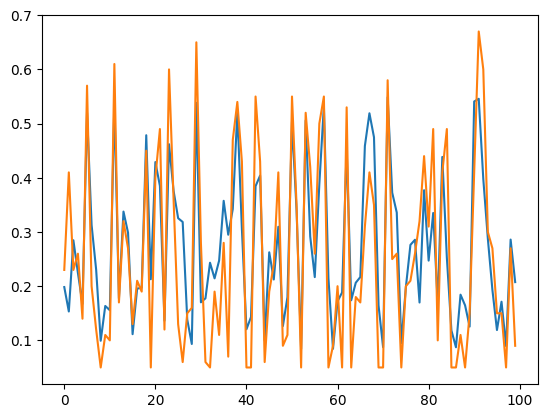

In [140]:
import matplotlib.pyplot as plt

new_x = [i for i in range(len(x.numpy()))]

# y_pred_plot = []
# tmp = y_train[:100]
# y_train_plot_data = []
# for i in range(len(y.numpy())):
#     y_pred_plot.append(y.numpy()[i][0])
#     y_train_plot_data.append(tmp[i][0])
# plt.plot([i[0] for i in x.numpy()], y.numpy())
plt.plot(new_x, y.numpy())
plt.plot(new_x, y_train[:100])
plt.show()


# new_x